<h1> Growth Accounting

Using the growth accounting method of Kehoe & Prescott (2002) which does the following:

Assume that production takes a Cobb-Douglas form:

\begin{equation}
Y_{t} = A_{t}K_{t}^{\alpha}N_{t}^{1-\alpha}
\end{equation}

where $Y_{t}$ is output, $A_{t}$ is productivity, $N_{t}$ is labour and $\alpha$ is the capital share. Divide through by the working age population $L_{t}$ and rearrange to get:

\begin{equation}
\frac{Y_{t}}{L_{t}} = A_{t}^{\frac{1}{1-\alpha}}\Big(\frac{K_{t}}{Y_{t}}\Big)^\frac{\alpha}{1-\alpha}\Big(\frac{N_{t}}{L_{t}}\Big)
\end{equation}

We can get data for $Y_{t}$ (GDP), $L_{t}$ (working age population), $K_{t}/Y_{t}$ (capital-ouput ratio) and $N_{t}/L_{t}$ (labour force participation).









<h3> Let's start by downloading some useful 'add-on' packages

In [1]:
# import some useful packages
%matplotlib inline
import numpy as np
import sympy as sym
from pylab import *
import wbdata
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import csv

<h3> Choose a country!

In [2]:
country = 'United States' # INSERT A STRING HERE
# find the World Bank country code 
countryCodes = list(csv.reader(open('WBCountryCodes.csv')))
for line in countryCodes:
    if country in line:
        countryName = line[0]
        countryCode = line[1]

try:
    print('Yes, ' + countryName + ' is a country!')
except:
    print('Country not found, try again')

Yes, United States is a country!


<h3> Now - connect to the World Bank API and download the data:

In [3]:
# Download the data
# World Bank real GDP (output approach) constant 2005 $ 
GDP = wbdata.get_data("NY.GDP.MKTP.KD", countryCode)
# World Bank % aged (15-64) in population
WorkingAgeRatio =  wbdata.get_data('SP.POP.1564.TO.ZS', countryCode)
# World Bank Population total 
PopulationTotal = wbdata.get_data('SP.POP.TOTL', countryCode)
# World Bank participation rate 
ParticipationRate= wbdata.get_data('SL.TLF.CACT.NE.ZS', countryCode)  
# World Bank gross capital formation constant 2005 $
GrossCapitalFormation= wbdata.get_data('NE.GDI.TOTL.KD', countryCode)

In [4]:
data = np.array([[i['date'] for i in GDP],[ i['value'] for i in GDP],
                 [i['value'] for i in WorkingAgeRatio],
                 [i['value'] for i in PopulationTotal],
                 [i['value'] for i in ParticipationRate],
                 [i['value'] for i in GrossCapitalFormation]])
data = pd.DataFrame(data.T, 
                    columns = ['date','Y', 'WorkingAgeRatio','PopulationTotal','N_L','I'])
data = data.dropna()
data = data.astype(float)
data['date'] = data['date'].astype(int)

data['L'] = pd.Series(data.WorkingAgeRatio*data.PopulationTotal/100, index=data.index)
data['N_L'] = data['N_L']/100
data = data.drop(columns=['WorkingAgeRatio', 'PopulationTotal'])

print data

    date             Y       N_L             I             L
2   2017  1.734863e+13  0.628510  3.698080e+12  2.136935e+08
3   2016  1.697235e+13  0.627863  3.555897e+12  2.130429e+08
4   2015  1.671046e+13  0.626513  3.589226e+12  2.121180e+08
5   2014  1.624253e+13  0.628853  3.437575e+12  2.111413e+08
6   2013  1.585380e+13  0.632488  3.300020e+12  2.101086e+08
7   2012  1.556704e+13  0.637010  3.152913e+12  2.090886e+08
8   2011  1.522455e+13  0.641091  2.928502e+12  2.079005e+08
9   2010  1.499205e+13  0.647055  2.809976e+12  2.066714e+08
10  2009  1.461730e+13  0.653696  2.543942e+12  2.051629e+08
11  2008  1.499776e+13  0.659942  3.050140e+12  2.033782e+08
12  2007  1.501827e+13  0.660397  3.252227e+12  2.013376e+08
13  2006  1.474169e+13  0.661791  3.305757e+12  1.993224e+08
14  2005  1.433250e+13  0.660469  3.207691e+12  1.974262e+08
15  2004  1.384606e+13  0.659936  3.037326e+12  1.950596e+08
16  2003  1.333931e+13  0.662437  2.816907e+12  1.927888e+08
17  2002  1.296826e+13  

/Users/Rachel/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


<h3> Create some functions that manipulate the data 

Functions take the following form:

    def:  says to Python that we are defining a function
    
    functionName: give the function a memorable name
    
    (...): the arguments in the bracket are passed to the function
    
    return: says what the function spits out 

In [5]:
#### Functions
# Create a function which calculate the capital series for given K0, delta, T
def calculateCapitalSeries(I, K0,delta,T):        
    K = np.array([K0])
    for t in range(1,T):
        K = np.append(K, K[t-1]*(1.0-delta) + I[t])
    return K


# Create a function which calculates the average of the first ten years' K/Y
def calculateAverageK_Y(K_Y):
    return (1.0/10.0)*np.sum(K_Y[1:11])

# Create a function to calculate the initial capital stock needed to give K/Y ratio
# this uses the perpetual inventory method
def calculateInitialCapStock(I,K0,Y,alpha,delta,T,tol=1e-08):
    err=100.0
    while err>tol:
        tempK = calculateCapitalSeries(I,K0,delta,T)
        tempK0_Y0 = calculateAverageK_Y(tempK/Y)
        K0 = tempK0_Y0*Y[0]
        err = (tempK0_Y0 - tempK[0]/Y[0])**2.0
    return K0
    
# Create a function that does the a
def growthAccounting(data,delta,alpha,K0):
    Y = np.array(data.Y)
    T = len(data.index)
    N_L = np.array(data.N_L)
    L = np.array(data.L)
    I = np.array(data.I)
    # find initial capital stock
    K0 = calculateInitialCapStock(I,K0,Y,alpha,delta,T)
    # calculate the capital series given initial conditions
    K = calculateCapitalSeries(I,K0,delta,T)
    # calculate capital/output ratio
    K_Y = K/Y
    # calculate output per effective worker
    Y_L = Y/L
    # calculate (K/Y)^(alpha/(1-alpha))
    K_Y_alpha_1minusalpha =(K_Y)**(alpha/(1-alpha))
    # calculate total factor productivity (TFP)
    TFP = (Y_L/(K_Y_alpha_1minusalpha*N_L))**(1-alpha)
    # calculate percentage change and take centered moving average
    TFP = percentageChange(TFP**(1/(1-alpha)),T)
    N_L = percentageChange(N_L,T)
    K_Y = percentageChange(K_Y_alpha_1minusalpha,T)
    Y_L = percentageChange(Y_L,T)
    return TFP,K_Y,Y_L,N_L,np.array(data.date)[0:T-1]

def movingAverage(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# calculate percentage changes
def percentageChange(series,T):
    d_series = np.zeros((T-1,1))
    for t in range(0,T-1):
        d_series[t] = 100*((series[t+1]/series[t])-1)
    return np.array(d_series)

<h3> Do the Growth Accounting!

Using the functions defined above, all we need to do is specify parameters ($\delta$ and $\alpha$), and an intitial value for the capital stock $k_0$, and pass some data! 

In [6]:
delta = 0.2
alpha = 0.3
K0= 100
[TFP,K_Y,Y_L,N_L,date] =  growthAccounting(data,delta,alpha,K0)

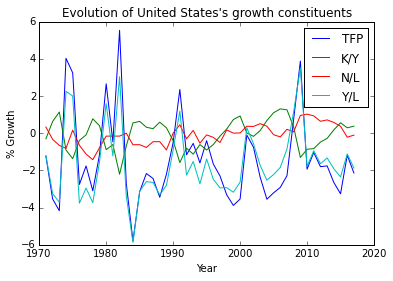

In [7]:

# plot the growth constituents
plt.plot(date,TFP,label='TFP')
plt.plot(date,K_Y,label='K/Y')
plt.plot(date,N_L,label='N/L')
plt.plot(date,Y_L,label='Y/L')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Year')
#plt.ylim([min_axes,max_axes])
plt.ylabel('% Growth')
plt.title("Evolution of " + country + "'s growth constituents", fontsize=12)
plt.legend(loc='best')
plt.draw()